##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

## Import TensorFlow and other libraries

In [ ]:
# we are using the code from pix2pix that mention in the paper with our modifications,
# and here is the address of the original colab related to pix2pix.

# To ensure that our training data is not lost after disconnection, I utilized Google Drive to store both the data and the trained model.
import os
from google.colab import drive
MOUNTPOINT = '/content/mnt'
DATADIR = os.path.join(MOUNTPOINT, 'colab_data')
drive.mount(MOUNTPOINT)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [ ]:
# After completing the experiment, you can unmount the drive.
drive.flush_and_unmount()

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Load the dataset

In [ ]:
# define the path for loading the data
PATH = pathlib.Path("/content/mnt/MyDrive/colab_data/data")

In [ ]:
# showing all directories
list(PATH.parent.iterdir())

[PosixPath('/content/mnt/MyDrive/colab_data/.ipynb_checkpoints'),
 PosixPath('/content/mnt/MyDrive/colab_data/data'),
 PosixPath('/content/mnt/MyDrive/colab_data/logs'),
 PosixPath('/content/mnt/MyDrive/colab_data/predictedimg'),
 PosixPath('/content/mnt/MyDrive/colab_data/training_checkpoints'),
 PosixPath('/content/mnt/MyDrive/colab_data/images-copies')]

Each original image is of size `256 x 512` containing two `256 x 256` images:

In [ ]:
sample_image = tf.io.read_file(str(PATH / '/content/mnt/MyDrive/colab_data/data/AB/train/149.png'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


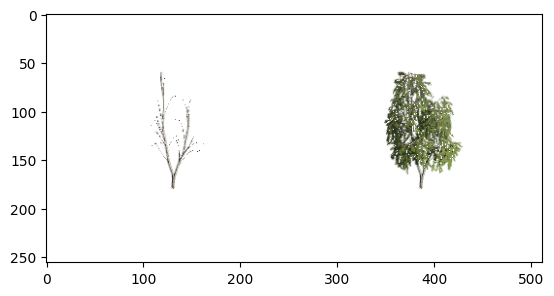

In [ ]:
plt.figure()
plt.imshow(sample_image)

Loading the image file

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (tree with leaves) and real (tree without leaves) images:

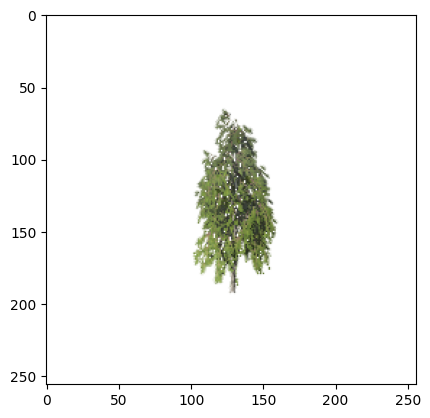

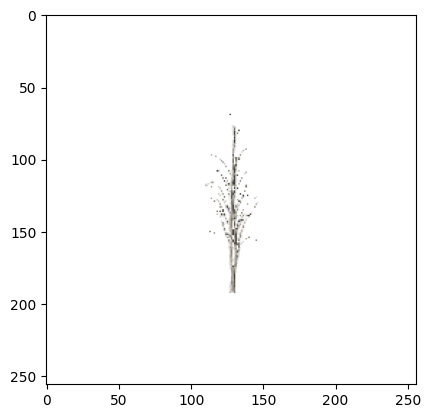

In [ ]:
inp, re = load(str(PATH / '/content/mnt/MyDrive/colab_data/data/AB/train/115.png'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}

In [ ]:
# The Tree training set consist of 200 images
BUFFER_SIZE = 200
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

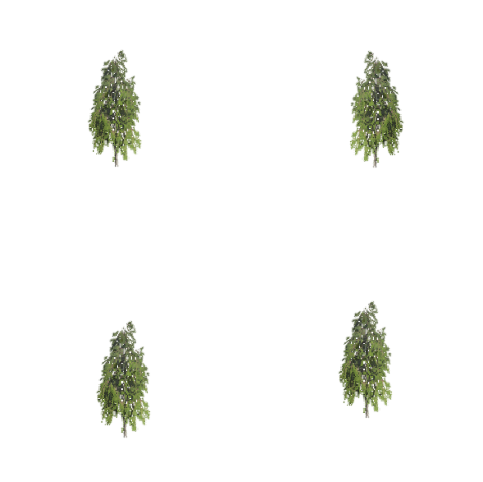

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [ ]:
# After downloading the data, change to your specified path.
train_dataset = tf.data.Dataset.list_files(str(PATH / '/content/mnt/MyDrive/colab_data/data/AB/train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# After downloading the data, change to your specified path.
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / '/content/mnt/MyDrive/colab_data/data/AB/test/*.png'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / '/content/mnt/MyDrive/colab_data/data/AB/val/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

Test the generator:

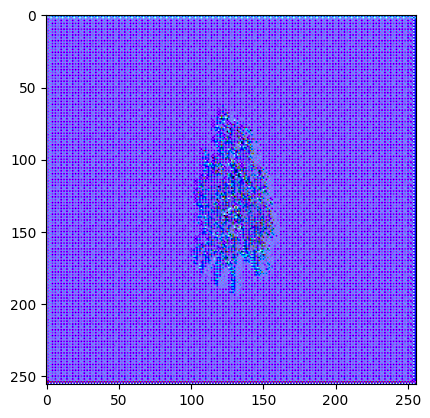

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

# Define the weighted map function:

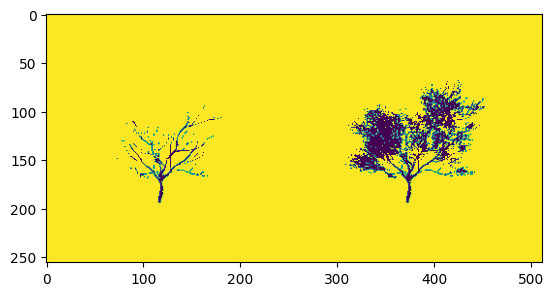

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# checking the number of zero's and one's
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

# weighted map function that make binary mask
def generate_weighted_map(image, threshold=128, foreground_weight=1.0, background_weight=0.5):
    if isinstance(image, str):
        # If the input is a string, assume it's a file path and read the image
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        image = tf.convert_to_tensor(image, dtype=tf.uint8)
    else:
        # If the input is a NumPy array or symbolic tensor, proceed as usual
        image = tf.convert_to_tensor(image, dtype=tf.uint8)

    # Thresholding operation using TensorFlow
    binary_mask = tf.cast(image > threshold, tf.uint8) * 255
    binary_mask = tf.cast(binary_mask, tf.float32)

    # Compute the weighted map
    weighted_map = binary_mask / 255.0 * foreground_weight + (1 - binary_mask / 255.0) * background_weight
    # print(weighted_map)
    return weighted_map


image_path = '/content/mnt/MyDrive/colab_data/data/AB/train/169.png'
weighted_map_from_path = generate_weighted_map(image_path)

image_array = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
weighted_map_from_array = generate_weighted_map(image_array)

plt.imshow(weighted_map_from_path)
plt.show()

### Define the generator loss

In [ ]:
LAMBDA = 100

In [ ]:
# ex2 : create the loss object with MeanAbsoluteError.
loss_object = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2, from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):

  # ex4 : create the loss object with BinaryFocalCrossentropy, pass the weighted map to for better performance.
  # gen_output_gray = tf.image.rgb_to_grayscale(gen_output)
  # Ensure that the grayscale image has dtype uint8
  # gen_output_gray = tf.cast(gen_output_gray, tf.uint8)
  # Generate weighted map
  # weighted_map = generate_weighted_map(gen_output_gray)
  # gan_loss = loss_object(tf.ones_like(gen_output), gen_output, sample_weight=weighted_map)
  # l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  # ex3 : create the loss object with BinaryFocalCrossentropy.
  # target_gray = tf.image.rgb_to_grayscale(disc_generated_output)
  # target_gray = tf.cast(target_gray, tf.uint8)
  # weighted_map = generate_weighted_map(target_gray)
  # gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output))
  # l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  # ex1 : create the loss object with BinaryCrossentropy.
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

Let's define the discriminator:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

In [ ]:
discriminator = Discriminator()

Test the discriminator:

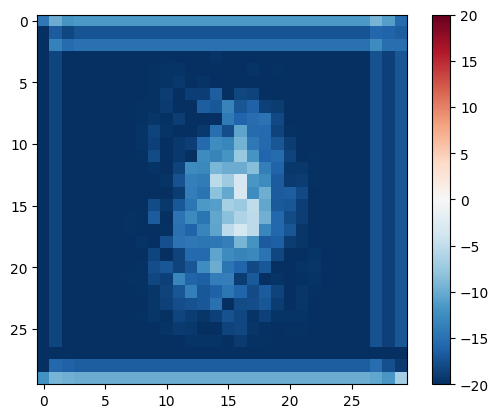

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/mnt/MyDrive/colab_data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

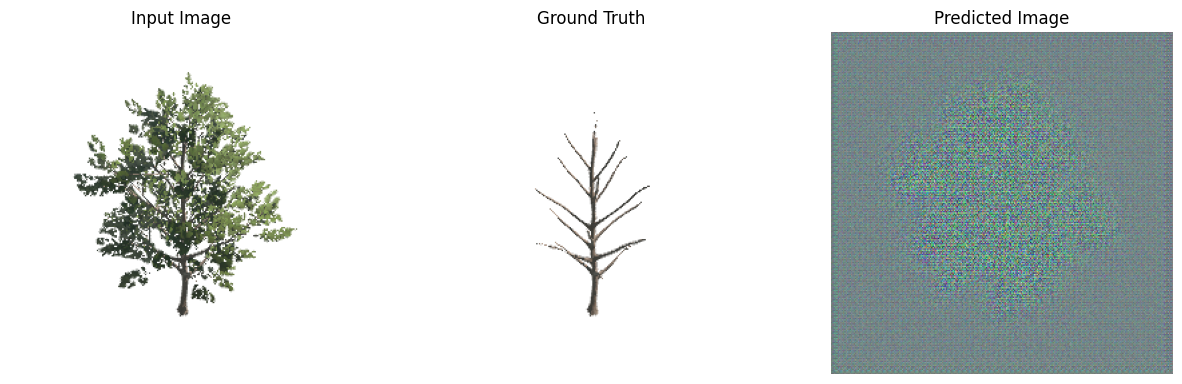

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

In [ ]:
log_dir="/content/mnt/MyDrive/colab_data/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Finally, run the training loop:

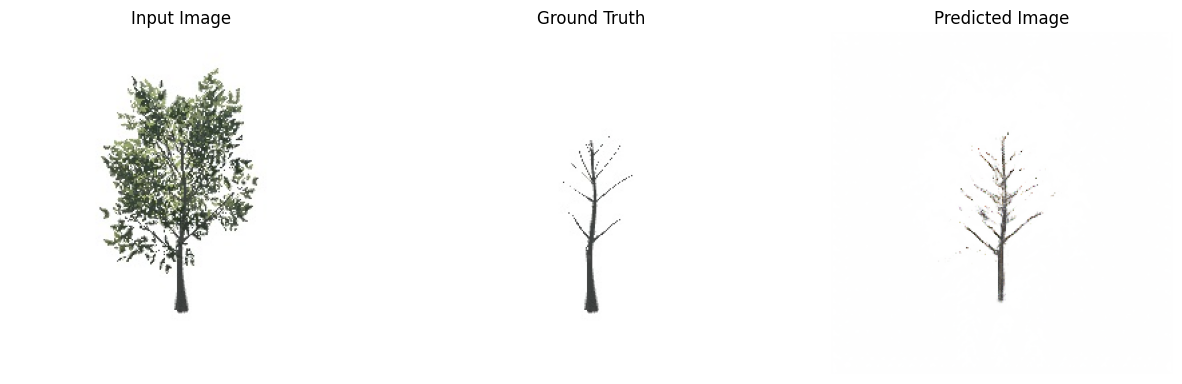

Step: 0k
....................................................................................................

In [160]:
fit(train_dataset, test_dataset, steps=40000)

## Restore the latest checkpoint and test the network

In [161]:
!ls {checkpoint_dir}

checkpoint		    ckpt-3.data-00000-of-00001	ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-3.index		ckpt-8.data-00000-of-00001
ckpt-1.index		    ckpt-4.data-00000-of-00001	ckpt-8.index


In [162]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print(checkpoint)

## Generate some images using the test set

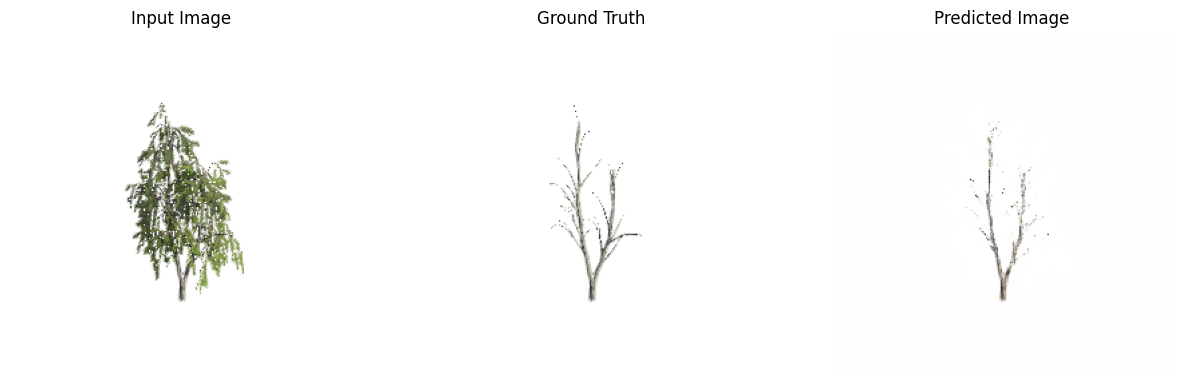

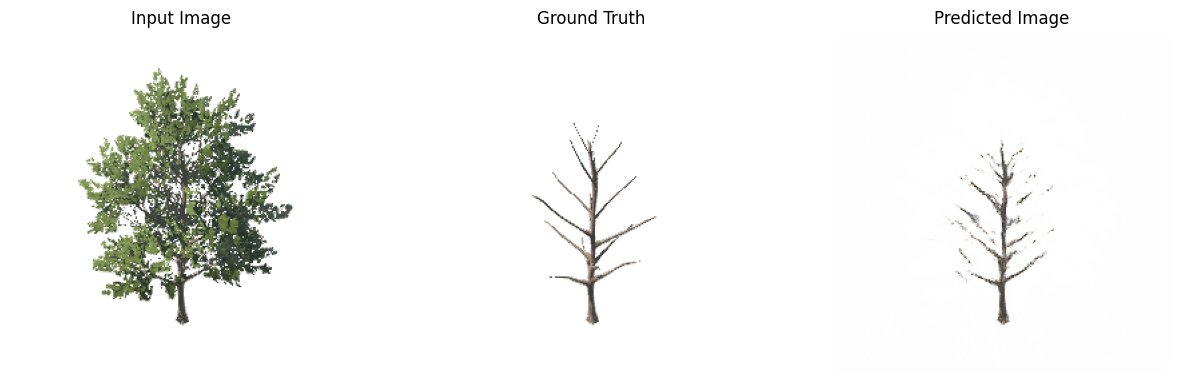

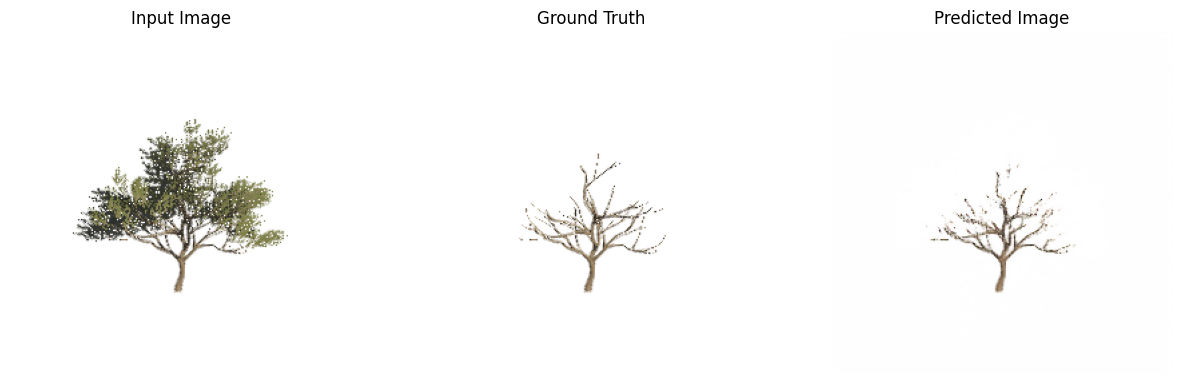

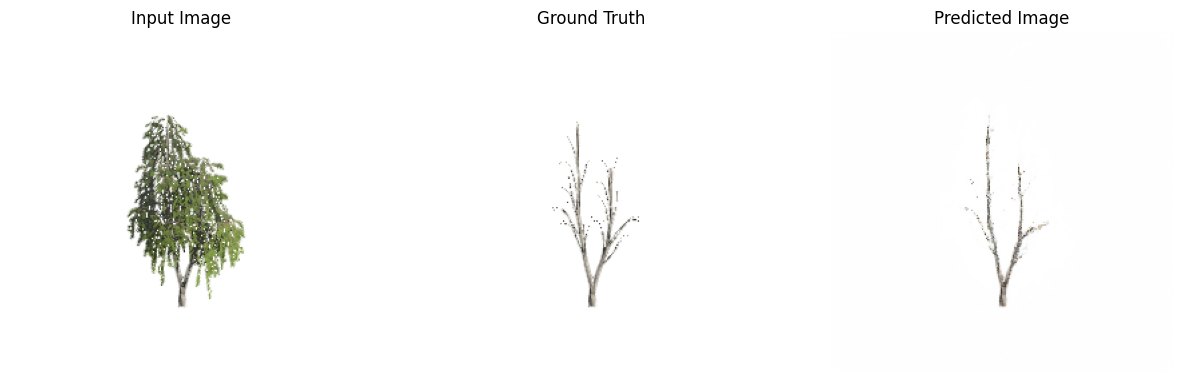

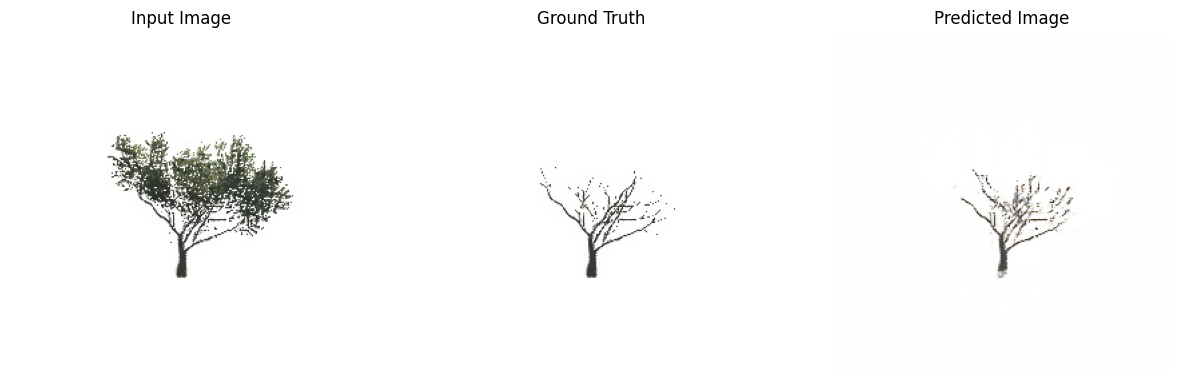

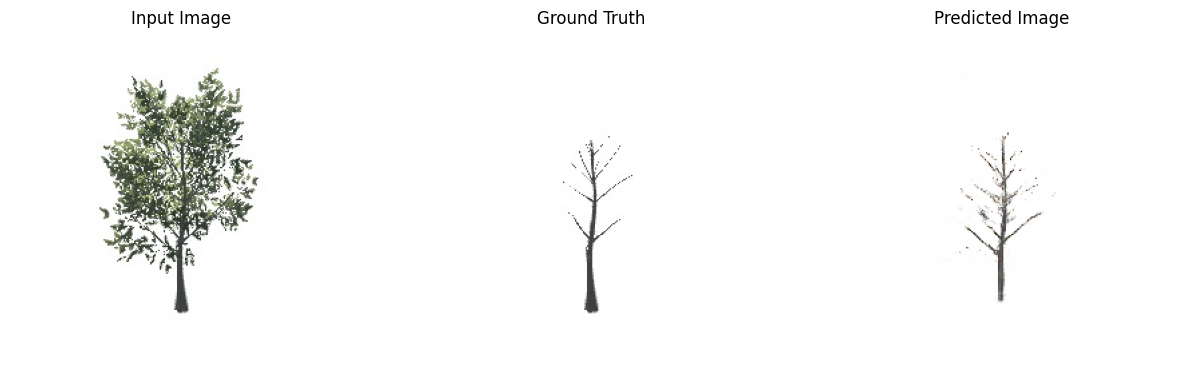

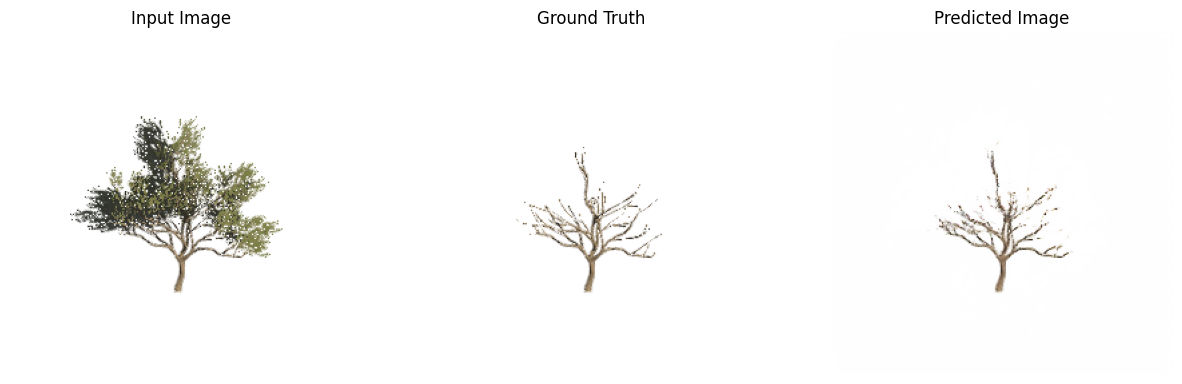

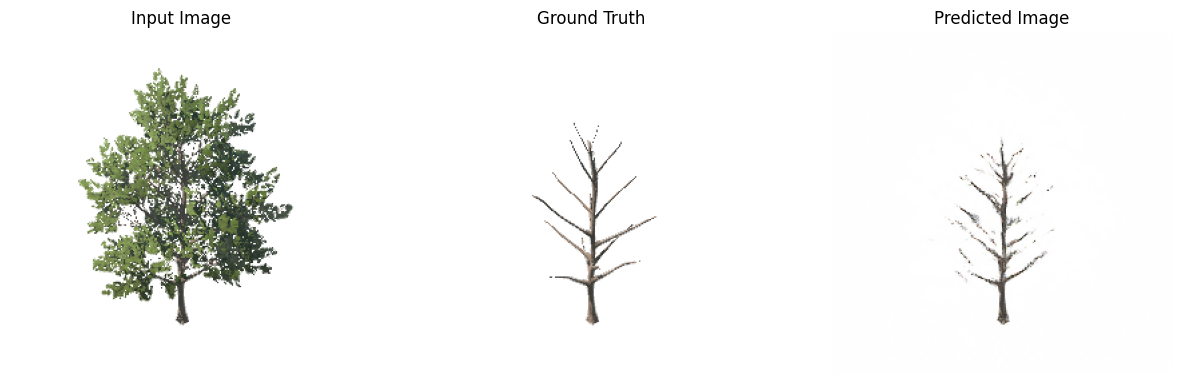

In [163]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(8):
  # print(tar)
  generate_images(generator, inp, tar)

# Hausdorff distance and Similarity

In [164]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage import metrics
from scipy.spatial.distance import directed_hausdorff
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


def hausdorff_distance(image1_path, image2_path):

    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate Hausdorff distance
    distance_1_to_2 = directed_hausdorff(image1_gray, image2_gray)[0]
    distance_2_to_1 = directed_hausdorff(image2_gray, image1_gray)[0]

    print(distance_1_to_2, "1-2")
    print(distance_2_to_1, "2-1")
    # Choose the maximum distance
    hausdorff_distance = max(distance_1_to_2, distance_2_to_1)
    print(hausdorff_distance, "max distance")
    return hausdorff_distance


# Calculate Mean Squared Error, HD and SSIM


In [166]:
def generate_images2(model, test_input, tar, title):
  prediction = model(test_input, training=True)
  display_list = [tar[0], prediction[0]]
  display_title = ['GT', 'PI']
  for i in range(2):
    plt.title(display_title[i] + "-" + title)
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    filename = "/content/mnt/MyDrive/colab_data/predictedimg/" + display_title[i] + "-" + title + ".png"
    plt.savefig(filename)
    plt.show()

  gt = "/content/mnt/MyDrive/colab_data/predictedimg/" + display_title[0] + "-" + title + ".png"
  pi = "/content/mnt/MyDrive/colab_data/predictedimg/" + display_title[1] + "-" + title + ".png"
  # Load the images
  image1 = cv2.imread(gt)
  image2 = cv2.imread(pi)

  # Ensure both images have the same shape
  image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_AREA)

  # Convert images to grayscale
  gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

  # Calculate Mean Squared Error (MSE)
  mse = np.mean((gray1 - gray2) ** 2)
  print(f"Mean Squared Error (MSE): {mse}")

  # Compute SSIM
  ssim_score = metrics.structural_similarity(gray1, gray2, full=True)
  print(f"SSIM Score: ", round(ssim_score[0],2))

  mse_result = mse
  ssim_result = round(ssim_score[0],2)

  hd = hausdorff_distance(gt, pi)
  hd_result = hd
  print(hd)
  resultss = pd.read_excel('results.xlsx')
  data = {'MSE': [mse_result], 'SSIM': [ssim_result], 'HDorf': [hd_result]}
  df = pd.DataFrame(data)
  combined_df = pd.concat([resultss, df], ignore_index=True)
  combined_df.to_excel('results.xlsx', index=False)

# Testing the similarity functions on different data to observe the results in edge cases.

In [168]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage import metrics
from scipy.spatial.distance import directed_hausdorff
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

def hausdorff_distance(image1_path, image2_path):

    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate Hausdorff distance
    distance_1_to_2 = directed_hausdorff(image1_gray, image2_gray)[0]
    distance_2_to_1 = directed_hausdorff(image2_gray, image1_gray)[0]

    print(distance_1_to_2, "1-2")
    print(distance_2_to_1, "2-1")
    # Choose the maximum distance
    hausdorff_distance = max(distance_1_to_2, distance_2_to_1)
    print(hausdorff_distance, "max distance")
    return hausdorff_distance


gt = "/content/mnt/MyDrive/colab_data/images-copies/111.png"
pi = "/content/mnt/MyDrive/colab_data/images-copies/pi0.png"
# Load the images
image1 = cv2.imread(gt)
image2 = cv2.imread(pi)

# Ensure both images have the same shape
image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_AREA)

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Calculate Mean Squared Error (MSE)
mse = np.mean((gray1 - gray2) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

# Compute SSIM
ssim_score = metrics.structural_similarity(gray1, gray2, full=True)
print(f"SSIM Score: ", round(ssim_score[0],2))
# ssim_value, _ = ssim(gray1, gray2, full=True)
# print(f"Structural Similarity Index (SSIM): {ssim_value}")
mse_result = mse
ssim_result = round(ssim_score[0],2)

# print(gt, pi)
hd = hausdorff_distance(gt, pi)
hd_result = hd
print(hd)

Mean Squared Error (MSE): 5.399932861328125
SSIM Score:  0.91
818.8791119573145 1-2
600.772835604274 2-1
818.8791119573145 max distance
818.8791119573145


# Generating images from the test set and displaying the results.

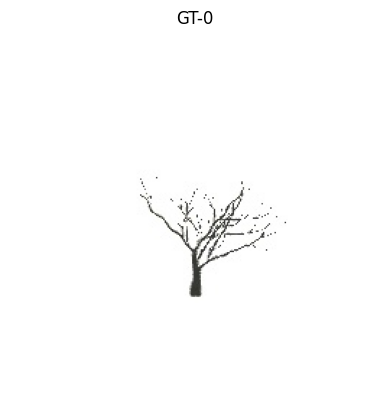

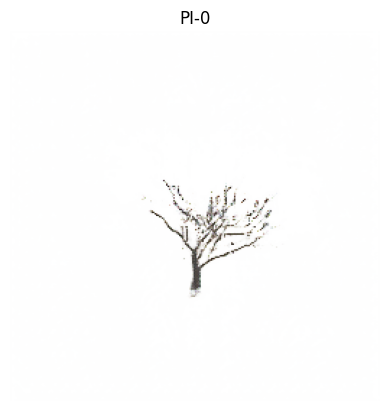

Mean Squared Error (MSE): 1.945615234375
SSIM Score:  0.98
733.5052828712279 1-2
681.1137937231928 2-1
733.5052828712279 max distance
733.5052828712279


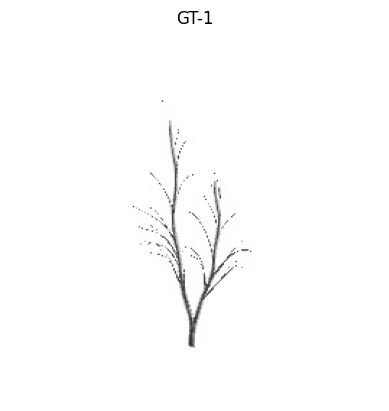

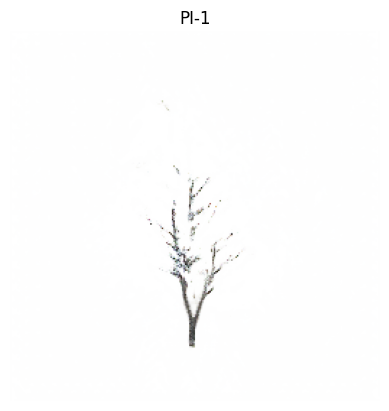

Mean Squared Error (MSE): 2.1237727864583333
SSIM Score:  0.97
748.5452558129001 1-2
550.6051216616133 2-1
748.5452558129001 max distance
748.5452558129001


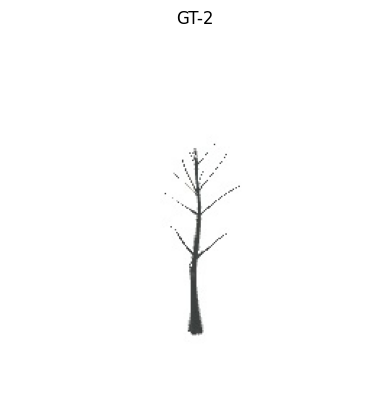

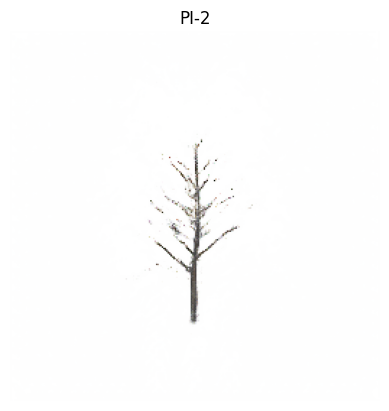

Mean Squared Error (MSE): 1.72201171875
SSIM Score:  0.98
738.6907336632835 1-2
726.36767549224 2-1
738.6907336632835 max distance
738.6907336632835


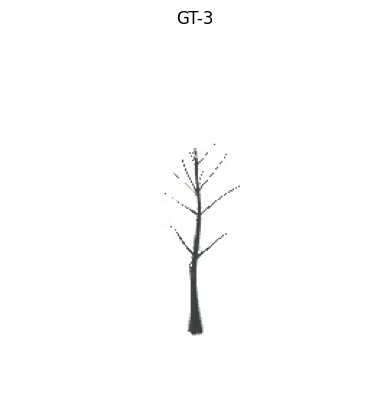

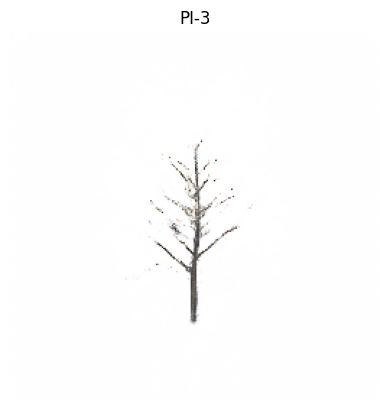

Mean Squared Error (MSE): 1.749921875
SSIM Score:  0.98
753.3106928751243 1-2
651.7975145702843 2-1
753.3106928751243 max distance
753.3106928751243


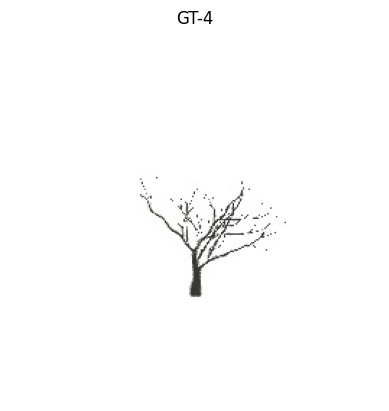

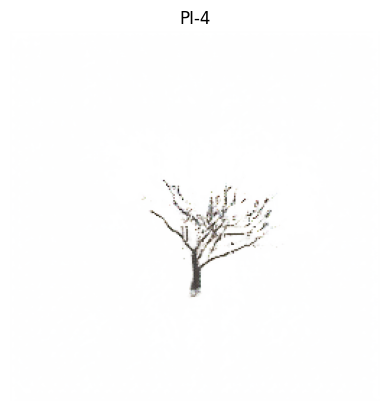

Mean Squared Error (MSE): 1.9412141927083333
SSIM Score:  0.98
753.3239674934018 1-2
706.5245926363781 2-1
753.3239674934018 max distance
753.3239674934018


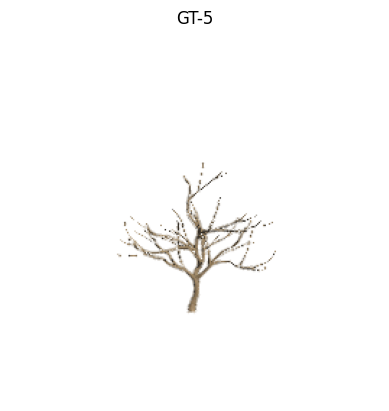

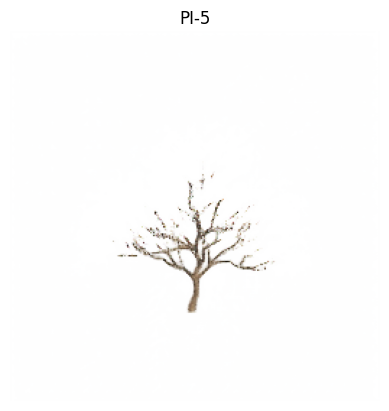

Mean Squared Error (MSE): 2.265478515625
SSIM Score:  0.98
788.1896979788559 1-2
616.8557367812996 2-1
788.1896979788559 max distance
788.1896979788559


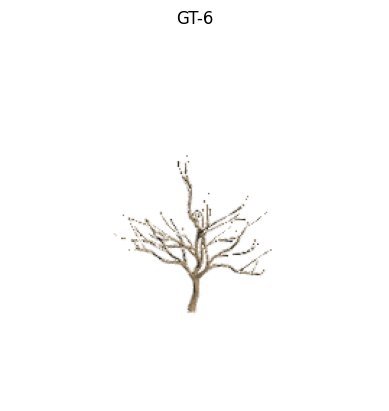

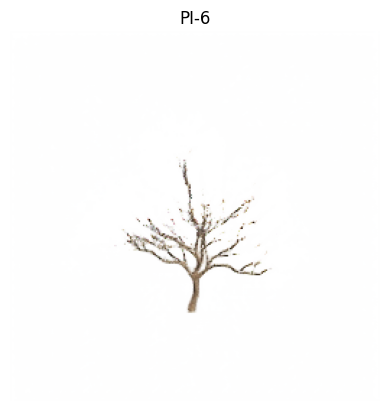

Mean Squared Error (MSE): 2.2467350260416667
SSIM Score:  0.98
817.0244794374279 1-2
682.4939560171944 2-1
817.0244794374279 max distance
817.0244794374279


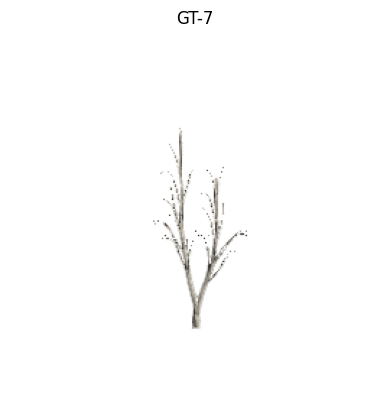

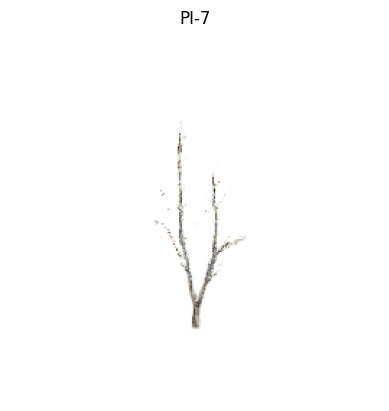

Mean Squared Error (MSE): 1.7581998697916668
SSIM Score:  0.98
909.4080492276281 1-2
722.7101770419454 2-1
909.4080492276281 max distance
909.4080492276281


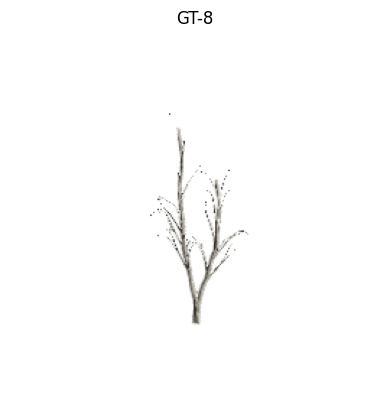

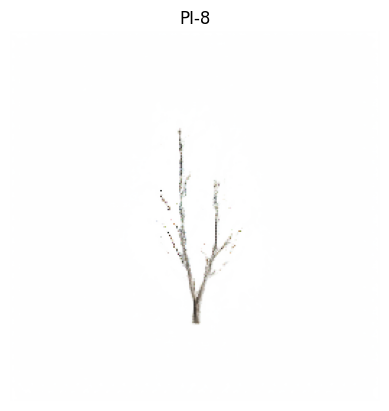

Mean Squared Error (MSE): 1.8366178385416667
SSIM Score:  0.98
793.5149652022953 1-2
615.5948342863186 2-1
793.5149652022953 max distance
793.5149652022953


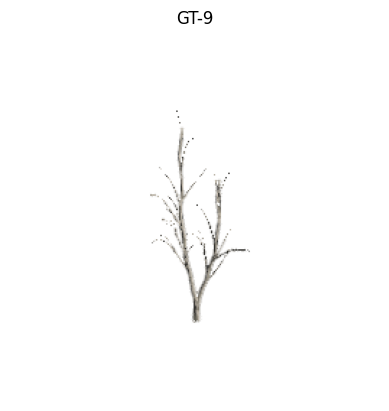

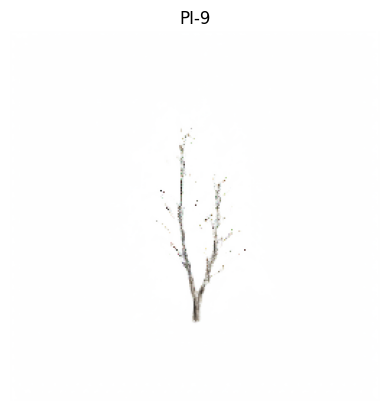

Mean Squared Error (MSE): 1.791611328125
SSIM Score:  0.98
732.491638177529 1-2
602.8416044036775 2-1
732.491638177529 max distance
732.491638177529


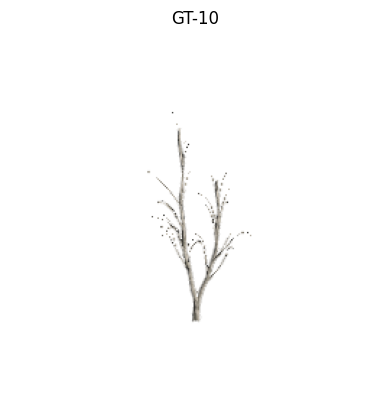

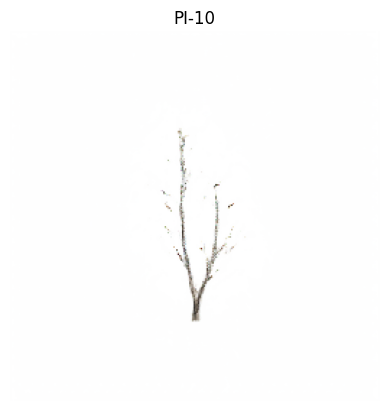

Mean Squared Error (MSE): 1.7900065104166667
SSIM Score:  0.98
874.1338570264854 1-2
764.1603234923938 2-1
874.1338570264854 max distance
874.1338570264854


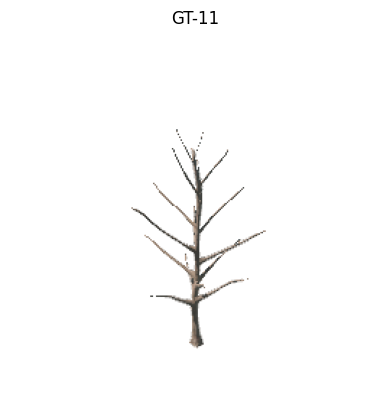

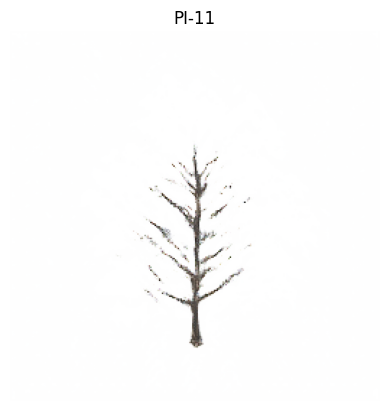

Mean Squared Error (MSE): 2.398447265625
SSIM Score:  0.97
938.2307818442113 1-2
734.825829703883 2-1
938.2307818442113 max distance
938.2307818442113


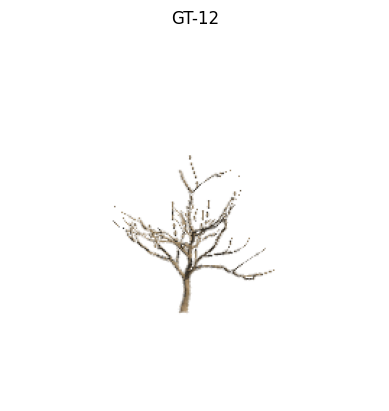

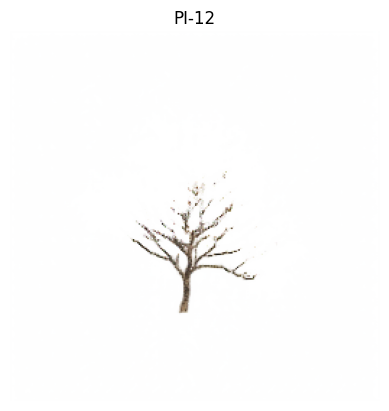

Mean Squared Error (MSE): 2.278154296875
SSIM Score:  0.98
808.4033646639529 1-2
846.262370662905 2-1
846.262370662905 max distance
846.262370662905


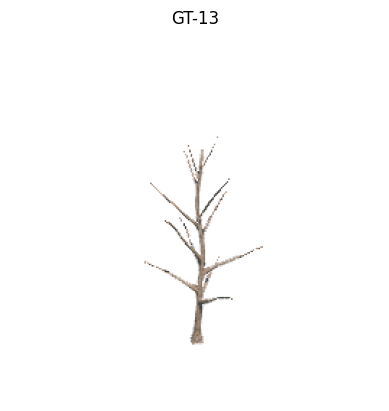

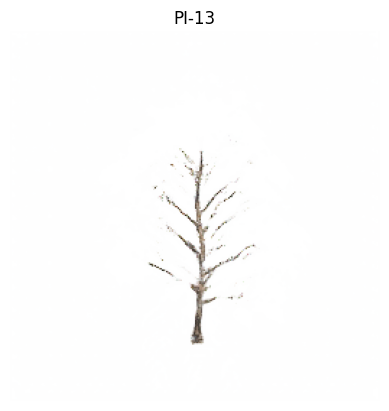

Mean Squared Error (MSE): 1.9085188802083333
SSIM Score:  0.98
869.4550017108419 1-2
709.8971756529251 2-1
869.4550017108419 max distance
869.4550017108419


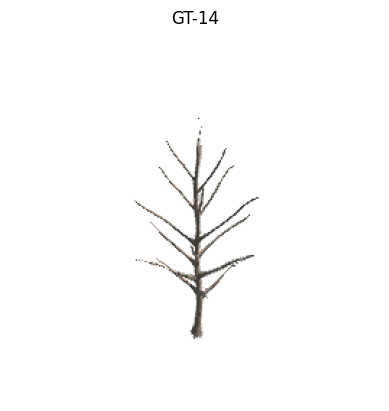

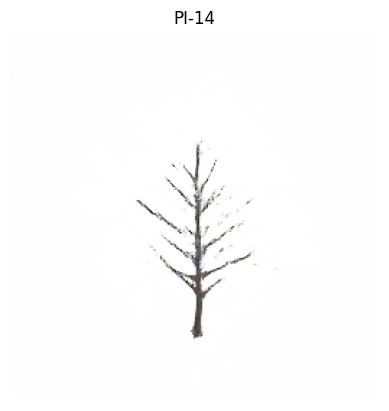

Mean Squared Error (MSE): 2.2078743489583332
SSIM Score:  0.98
794.238629128551 1-2
754.5906174873896 2-1
794.238629128551 max distance
794.238629128551


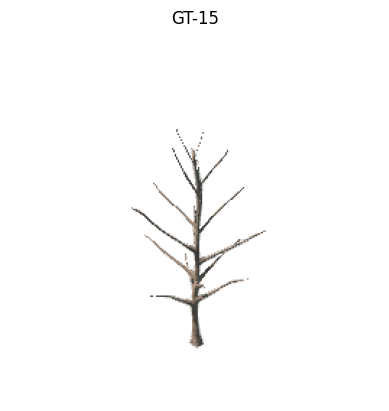

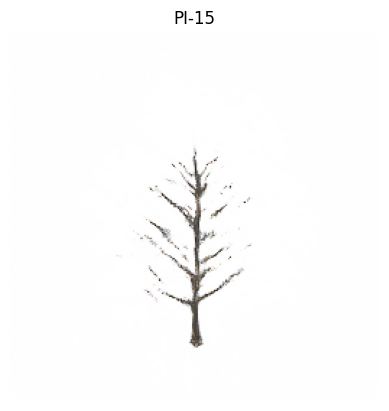

Mean Squared Error (MSE): 2.3870052083333335
SSIM Score:  0.97
946.15115071536 1-2
702.3218635355161 2-1
946.15115071536 max distance
946.15115071536


In [169]:
for i, (input, tar) in enumerate(test_dataset):
  generate_images2(generator, input, tar, str(i))
